<h1 align='center'>Perceptual Losses for Real-Time Style Transfer and Super-Resolution </center>
https://arxiv.org/abs/1603.08155   



<h2 align='center'> Supplementary Material </center>    
https://cs.stanford.edu/people/jcjohns/papers/fast-style/fast-style-supp.pdf

Play with VGG 

use tf backend 

In [316]:
from keras.models import Sequential
from loss import *
from keras.layers import add, concatenate 
import keras 
from keras import applications
from keras import backend as K
from keras.models import Model
import h5py
from keras.datasets import mnist
from keras.layers import Reshape,Dense
import numpy as np
from keras.layers import UpSampling2D,MaxPool2D,Conv2D,Activation,Dropout,BatchNormalization, Input ,Deconv2D ,Conv2DTranspose
from keras.models import Sequential
import matplotlib.pyplot as plt
from scipy.misc import imresize
from scipy import ndimage as nd
import myplot
from skimage.measure import compare_psnr,compare_ssim
from tqdm import tqdm_notebook as tqdm
from keras.preprocessing.image import ImageDataGenerator
from skimage.color import ycbcr2rgb,rgb2ycbcr
from scipy.misc import imread
from keras.models import load_model
from keras.engine.topology import Layer
from keras.utils.data_utils import get_file
import img_utils
from keras.applications import VGG16

In [260]:
down=np.load('BSD100-SRF_4.npz')
LR_images = down['LR']
HR_images = down['HR']
LR_images=LR_images.astype('uint8')
HR_images=HR_images.astype('uint8')
THEANO_WEIGHTS_PATH_NO_TOP = r'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_th_dim_ordering_th_kernels_notop.h5'
TENSORFLOW_WEIGHTS_PATH_NO_TOP = r"https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
style_image_path = './Fast-Neural-Style/images/inputs/blue-moon-lake.jpg'

In [159]:
#Original_image = np.reshape(LR_images,(LR_images.shape[0],LR_images.shape[1],LR_images.shape[2],1))
print 'shape of original image is %d x %d  x%d  x%d ' %HR_images.shape
#LR_mnist = np.reshape(LR_mnist,(LR_mnist.shape[0],LR_mnist.shape[1],LR_mnist.shape[2],1))
print 'shape of downsample image is  %d x %d  x%d  x%d  ' %LR_images.shape 

shape of original image is 100 x 320  x480  x3 
shape of downsample image is  100 x 80  x120  x3  


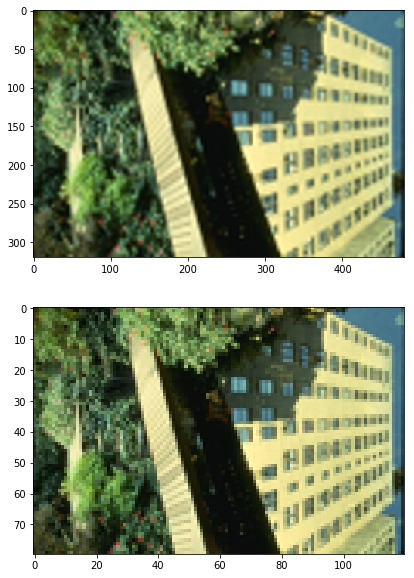

In [160]:
temp_bicubic= []
for index in tqdm(range(len(LR_images))):
    temp_bicubic.append(imresize(LR_images[index],size=4.0,interp='bicubic'))
bicubic_LR =np.array(temp_bicubic)
# bicubic_mnist = np.reshape(bicubic_mnist,(bicubic_mnist.shape[0],bicubic_mnist.shape[1],bicubic_mnist.shape[2],1))
plt.figure(figsize=(10,10))
plt.subplot(211)
plt.imshow(bicubic_LR[20])
plt.subplot(212)
plt.imshow(LR_images[20])
plt.show()

value_of_L =[]
value_of_H = []

for L_image,H_image in tqdm(zip(bicubic_LR,HR_images)):
    value_of_L.append(rgb2ycbcr(L_image))
    value_of_H.append(rgb2ycbcr(H_image))

HR_ycbcr= np.stack(value_of_H)
LR_ycbcr= np.stack(value_of_L)



In [161]:
LR_Y_channel = (LR_ycbcr[:,:,:,0]-127.5)/128
HR_Y_channel =(HR_ycbcr[:,:,:,0]-127.5)/128
# bicubic_LR=(bicubic_LR-127.5)/128
LR_Y_channel = np.reshape(LR_Y_channel,(LR_Y_channel.shape[0],LR_Y_channel.shape[1],LR_Y_channel.shape[2],1))

HR_Y_channel = np.reshape(HR_Y_channel,(HR_Y_channel.shape[0],HR_Y_channel.shape[1],HR_Y_channel.shape[2],1))
print 'Max of LR_mnist is %f, Min of LR_mnist is %f' %(LR_Y_channel.max() ,LR_Y_channel.min() )
print 'Max of Original_image is %f, Min of Original_image is %f' %(LR_Y_channel.max() ,LR_Y_channel.min() )


Max of LR_mnist is 0.839844, Min of LR_mnist is -0.871094
Max of Original_image is 0.839844, Min of Original_image is -0.871094


In [162]:
LR_Y_channel.shape

(100, 320, 480, 1)

In [170]:
def Resi_block(x):
    y = Conv2D(32, (3, 3), padding='same')(x)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Conv2D(32, (3, 3), padding='same')(y)
    y = BatchNormalization()(y)
    y = add([x,y])
    return y

In [171]:
def residual_block(ip, id):
    init = ip
    x = Conv2D(128, (3,3), activation='linear', padding='same',
                          name='res_conv_' + str(id) + '_1')(ip)
    x = BatchNormalization(axis=1,name="res_batchnorm_" + str(id) + "_1")(x)
    x = Activation('relu', name="res_activation_" + str(id) + "_1")(x)
    #x = ReflectionPadding2D()(x)
    x = Conv2D(feature, (3,3), activation='linear', padding='same',
                       name='res_conv_' + str(id) + '_2')(x)
    x = BatchNormalization(axis=1, name="res_batchnorm_" + str(id) + "_2")(x)
    m = add([x,init],name='res_merge_'+str(id))
    #m = merge([x, init], mode='sum', name="res_merge_" + str(id))
        #m = Activation('relu', name="res_activation_" + str(id))(m)
    return m

In [199]:
def pooling_func(x, pooltype):
    '''
    Pooling function used in VGG

    Args:
        x: previous layer
        pooltype: int, 1 refers to AveragePooling2D. All other values refer to MaxPooling2D

    Returns:

    '''
    if pooltype == 1:
        return AveragePooling2D((2, 2), strides=(2, 2))(x)
    else:
        return MaxPool2D((2, 2), strides=(2, 2))(x)

In [200]:
class VGGNormalize(Layer):
    '''
    Custom layer to subtract the outputs of previous layer by 120,
    to normalize the inputs to the VGG network.
    '''

    def __init__(self, **kwargs):
        super(VGGNormalize, self).__init__(**kwargs)

    def build(self, input_shape):
        pass

    def call(self, x, mask=None):
        '''
        Since individual channels cannot be altered in a TensorVariable, therefore
        we subtract it by 120, similar to the chainer implementation.
        '''
        if K.backend() == "theano":
            import theano.tensor as T
            #x = T.set_subtensor(x[:, :, :, :], x[:, ::-1, :, :]) # RGB -> BGR
            x = T.set_subtensor(x[:, 0, :, :], x[:, 0, :, :] - 103.939)
            x = T.set_subtensor(x[:, 1, :, :], x[:, 1, :, :] - 116.779)
            x = T.set_subtensor(x[:, 2, :, :], x[:, 2, :, :] - 123.680)
            #x -= 120
        else:
            # No exact substitute for set_subtensor in tensorflow
            # So we subtract an approximate value
            x -= 120
        return x

    def compute_output_shape(self, input_shape):
        return input_shape

In [262]:
class VGG:
    '''
    Helper class to load VGG and its weights to the FastNet model
    '''

    def __init__(self, img_height=256, img_width=256):
        self.img_height = img_height
        self.img_width = img_width

    def append_vgg_model(self, model_input, x_in, pool_type=0):
        '''
        Adds the VGG model to the FastNet model. It concatenates the original input to the output generated
        by the FastNet model. This is used to compute output features of VGG for the input image.

        Then it rescales the FastNet outputs and initial input to range [-127.5, 127.5] with lambda layer
        Ideally, I would like to subtract the channel means individually, but that is not efficient.
        Therefore, the closest approximate is to scale the values in the range [-127.5, 127.5]

        After this it adds the VGG layers.

        Args:
            model_input: Input to the FastNet model
            x_in: Output of last layer of FastNet model
            pool_type: int, 1 = AveragePooling, otherwise uses MaxPooling

        Returns: Model (FastNet + VGG)

        '''

        if K.image_dim_ordering() == "th":
            true_X_input = Input(shape=(3, self.img_width, self.img_height))
        else:
            true_X_input = Input(shape=(self.img_width, self.img_height, 3))

        # Append the initial input to the FastNet input to the VGG inputs
        x = concatenate([x_in, true_X_input],axis=0)
        
        print x.shape
        
        # Normalize the inputs via custom VGG Normalization layer
        x = VGGNormalize(name="vgg_normalize")(x)

        # Begin adding the VGG layers
        x = Conv2D(64, (3, 3), activation='relu', name='conv1_1')(x)
        x = Conv2D(64, (3, 3), activation='relu', name='conv1_2', padding='same')(x)
        x = pooling_func(x, pool_type)

        x = Conv2D(128, (3, 3), activation='relu', name='conv2_1', padding='same')(x)
        x = Conv2D(128, (3, 3), activation='relu', name='conv2_2', padding='same')(x)
        x = pooling_func(x, pool_type)

        x = Conv2D(256, (3, 3), activation='relu', name='conv3_1', padding='same')(x)
        x = Conv2D(256, (3, 3), activation='relu', name='conv3_2', padding='same')(x)
        x = Conv2D(256, (3, 3), activation='relu', name='conv3_3', padding='same')(x)
        x = pooling_func(x, pool_type)

        x = Conv2D(512, (3, 3), activation='relu', name='conv4_1', padding='same')(x)
        x = Conv2D(512, (3, 3), activation='relu', name='conv4_2', padding='same')(x)
        x = Conv2D(512, (3, 3), activation='relu', name='conv4_3', padding='same')(x)
        x = pooling_func(x, pool_type)

        x = Conv2D(512, (3, 3), activation='relu', name='conv5_1', padding='same')(x)
        x = Conv2D(512, (3, 3), activation='relu', name='conv5_2', padding='same')(x)
        x = Conv2D(512, (3, 3), activation='relu', name='conv5_3', padding='same')(x)
        x = pooling_func(x, pool_type)

        model = Model([model_input, true_X_input], x)

        # Loading VGG 16 weights
        if K.image_dim_ordering() == "th":
            weights_name = "vgg16_weights_th_dim_ordering_th_kernels_notop.h5"
            weights_path = THEANO_WEIGHTS_PATH_NO_TOP
        else:
            weights_name = "vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
            weights_path = TENSORFLOW_WEIGHTS_PATH_NO_TOP

        weights = get_file(weights_name, weights_path, cache_subdir='models')
        f = h5py.File(weights)

        layer_names = [name for name in f.attrs['layer_names']]

        for i, layer in enumerate(model.layers[-18:]):
            g = f[layer_names[i]]
            weights = [g[name] for name in g.attrs['weight_names']]
            #print layer.shape
            layer.set_weights(weights)
            
        print('VGG Model weights loaded.')

        # Freeze all VGG layers
        for layer in model.layers[-19:]:
            layer.trainable = False

        self.model = model
        return model

In [311]:
def fastnet_predict(input_img):
        '''
        Function to get predictions of FastNet model

        Args:
            input_img: input image of shape determined by image_dim_ordering

        Returns: styled (predicted) image

        '''
        fastnet_predict_func = K.function([model.layers[0].input],
                                                   fastnet_outputs_dict['fastnet_output'])
        return fastnet_predict_func([input_img])

def get_vgg_style_features(input_img):
        '''
        Function to get style features of VGG model

        Args:
            input_img: input image of shape determined by image_dim_ordering

        Returns: list of VGG output features
        '''
        vgg_style_func = K.function([model.layers[-19].input], style_layer_outputs)
        return vgg_style_func([input_img])

def get_vgg_content_features(input_img):
        '''
        Function to get content features of VGG model

        Args:
            input_img: input image of shape determined by image_dim_ordering

        Returns: VGG output features

        '''

        vgg_content_func = K.function([model.layers[-19].input], content_layer_output)
        return vgg_content_func([input_img])

In [263]:
class Denormalize(Layer):
    '''
    Custom layer to denormalize the final Convolution layer activations (tanh)

    Since tanh scales the output to the range (-1, 1), we add 1 to bring it to the
    range (0, 2). We then multiply it by 127.5 to scale the values to the range (0, 255)
    '''

    def __init__(self, **kwargs):
        super(Denormalize, self).__init__(**kwargs)

    def build(self, input_shape):
        pass

    def call(self, x, mask=None):
        '''
        Scales the tanh output activations from previous layer (-1, 1) to the
        range (0, 255)
        '''

        return (x + 1) * 127.5

    def compute_output_shape(self, input_shape):
        return input_shape

# 一级 variable 

In [264]:
(_,img_width,img_height,_) =  HR_ycbcr.shape   # size of image 
kernel_size=3                                  # default 3x3 
pool_type=0                                    #  Maxpool 
style_weight=5                              # weight to style loss  author use 10 
content_weight=1                             # weight to style loss author use 1 
tv_weight=1e3                                #  weight to total variation loss 
model_width="thin"                          #  'thin' or 'wide'  nb_filters either 64 or 128
feature = 64
model_depth="shallow"                       #  'shallow ' or 'deep '  / original paper use shallow or more deep nets 
save_fastnet_model=None                     # 

## 其他参数 

In [265]:
train_mode=True 
mode =2 #？？

# Build Image Transform net 

In [266]:
ip = Input(shape=(img_width, img_height, 3), name="X_input") # input placer 

#### first layer 

In [267]:
# c1 = ReflectionPadding2D((4, 4))(ip)
c1 = Conv2D(32, (9, 9), activation='linear', padding='same', name='conv1')(ip)
c1_b = BatchNormalization(name="batchnorm1")(c1)
c1_b = Activation('relu')(c1_b)


#### secend layer 

In [268]:
c2 = Conv2D(feature, (3,3), activation='linear', padding='same', strides=(2, 2),
                           name='conv2')(c1_b)
c2_b = BatchNormalization(name="batchnorm2")(c2)
c2_b = Activation('relu')(c2_b)
        

#### 3rd layer

In [269]:
c3 = Conv2D(feature, (3,3), activation='linear', padding='same', strides=(2, 2),
                           name='conv3')(c2_b)
x = BatchNormalization(axis=1,name="batchnorm3")(c3)
x = Activation('relu')(x)
        

#### Residual net

In [270]:
r1 = residual_block(x, 1)
r2 = residual_block(r1, 2)
r3 = residual_block(r2, 3)
r4 = residual_block(r3, 4)
x = residual_block(r4, 5)
        

#### first TransposeConv2D

In [271]:
d3 = Conv2DTranspose(feature, (3,3), activation="linear", padding="same", strides=(2, 2),
                             name="deconv3")(x)

#d3 = Conv2DTranspose(64, (3,3), activation="linear", padding="same", strides=(2, 2),
 #                            output_shape=(1, 64, img_width // 2, img_height // 2),
#                             name="deconv3")(x)


d3 = BatchNormalization(axis=1, name="batchnorm4")(d3)
d3 = Activation('relu')(d3)
        

#### Second TransposeConv2D

In [272]:
d2 = Conv2DTranspose(feature, (3,3), activation="linear", padding="same", strides=(2, 2),
                              name="deconv2")(d3)
d2 = BatchNormalization(axis=1, name="batchnorm5")(d2)
d2 = Activation('relu')(d2)

#### Third  TransposeConv2D

In [319]:
# d1 = ReflectionPadding2D((4, 4))(d2)
d1 = Conv2D(3, (9, 9), activation='tanh', padding='same', name='fastnet_conv')(d2)

# Scale output to range [0, 255] via custom Denormalize layer
d1 = Denormalize(name='fastnet_output')(d1)

model = Model(ip, d1)

In [320]:
fastnet_outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
fastnet_output_layer = model.layers[-1]


# Add VGG layers to Fast Style Model

In [321]:
model.output

<tf.Tensor 'fastnet_output_8/mul:0' shape=(?, 320, ?, 3) dtype=float32>

In [322]:
model = VGG(img_height,img_width).append_vgg_model(model.input, x_in=model.output,
                                                                          pool_type=pool_type)


vgg_output_dict = dict([(layer.name, layer.output) for layer in model.layers[-18:]])

vgg_layers = dict([(layer.name, layer) for layer in model.layers[-18:]])

style = img_utils.preprocess_image(style_image_path,img_width, img_height)
print('Getting style features from VGG network.')

style_layers = ['conv1_2', 'conv2_2', 'conv3_3', 'conv4_3']

style_layer_outputs = []

(?, 320, 480, 3)
VGG Model weights loaded.
Getting style features from VGG network.


In [323]:
for layer in style_layers:
        style_layer_outputs.append(vgg_output_dict[layer])

        style_features = get_vgg_style_features(style)
        style_features = style_features
            # Style Reconstruction Loss
if style_weight != 0.0:
    for i, layer_name in enumerate(style_layers):
        layer = vgg_layers[layer_name]
        style_loss = StyleReconstructionRegularizer(     
            style_feature_target=style_features[i][0],
                    weight=style_weight)(layer)
        layer.add_loss(style_loss)

            # Feature Reconstruction Loss
content_layer = 'conv4_2'
content_layer_output = vgg_output_dict[self.content_layer]
if self.content_weight != 0.0: 
    layer = vgg_layers[self.content_layer]
    content_regularizer = FeatureReconstructionRegularizer( weight=content_weight)(layer)
    layer.add_loss(content_regularizer)

        # Total Variation Regularization
if self.tv_weight != 0.0:
    layer = fastnet_output_layer  # Fastnet Output layer
    tv_regularizer = TVRegularizer(img_width=self.img_width, img_height=img_height,
                                           weight=tv_weight)(layer)
    layer.add_loss(tv_regularizer)

  

TypeError: 'Tensor' object is not iterable.

In [ ]:
model.compile(loss='mse',optimizer='adam')

In [83]:
model.fit(x=LR_Y_channel,y=HR_Y_channel,epochs=6,batch_size=2)

Epoch 1/6
100/100 [==============================] - 14s - loss: 0.1835     

# Prediction

In [22]:
def super_resolution(image,model):
    # image is in RGB channel. after Bicubic ! 
    Image_to_test = rgb2ycbcr(image)
    Image_to_test_y_channel = Image_to_test[:,:,0]
    Image_to_test_y_channel =(Image_to_test_y_channel-127.5)/128
    Image_to_test_y_channel = np.reshape(Image_to_test_y_channel,(1,Image_to_test_y_channel.shape[0],Image_to_test_y_channel.shape[1],1))
    Image_to_test_y_channel_pred= model.predict(x=Image_to_test_y_channel)
    Image_to_test_y_channel_pred = np.reshape(Image_to_test_y_channel_pred,(Image_to_test_y_channel_pred.shape[1],Image_to_test_y_channel_pred.shape[2]))
    Image_to_test_y_channel_pred=(Image_to_test_y_channel_pred*128)+127.5
    Image_to_test[:,:,0]=Image_to_test_y_channel_pred
    exam_image_RGB = ycbcr2rgb(Image_to_test)
    exam_image_RGB[exam_image_RGB>1]=1
    exam_image_RGB[exam_image_RGB<0]=0
    exam_image_RGB *=255
    exam_image_RGB=exam_image_RGB.astype('uint8')
    return exam_image_RGB

In [23]:
index= 5

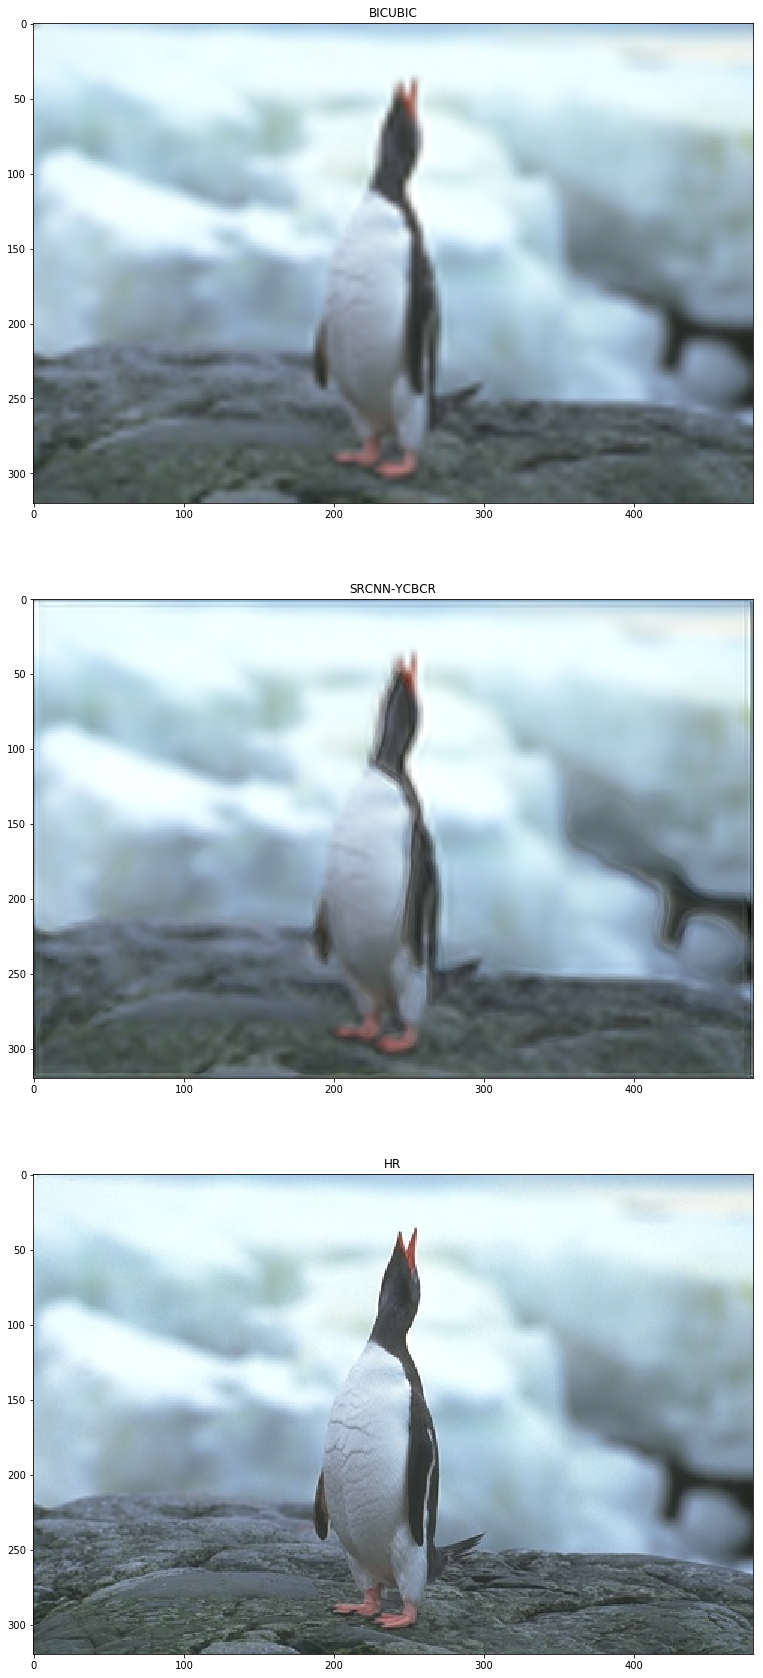

In [84]:
plt.figure(figsize=(20,30))
plt.subplot(311)
plt.title('BICUBIC')
plt.imshow(ycbcr2rgb(LR_ycbcr[index]))

plt.subplot(312)
plt.title('SRCNN-YCBCR')
plt.imshow(super_resolution(bicubic_LR[index],model))

plt.subplot(313)
plt.title('HR')
plt.imshow(HR_images[index])

plt.show()

In [102]:
for index in tqdm(range(100)):
    plt.figure(figsize=(20,30))
    plt.subplot(311)
    plt.title('BICUBIC')
    plt.imshow(ycbcr2rgb(LR_ycbcr[index]))

    plt.subplot(312)
    plt.title('SRCNN-YCBCR')
    plt.imshow(super_resolution(bicubic_LR[index],model))

    plt.subplot(313)
    plt.title('HR')
    plt.imshow(HR_images[index])

    path = './ResSRCNN_result/BSD100_SRF_4_YCBCR_'+str(index)
    print path
    plt.savefig(path)
    plt.close()

./ResSRCNN_result/BSD100_SRF_4_YCBCR_0
./ResSRCNN_result/BSD100_SRF_4_YCBCR_1
./ResSRCNN_result/BSD100_SRF_4_YCBCR_2
./ResSRCNN_result/BSD100_SRF_4_YCBCR_3
./ResSRCNN_result/BSD100_SRF_4_YCBCR_4
./ResSRCNN_result/BSD100_SRF_4_YCBCR_5
./ResSRCNN_result/BSD100_SRF_4_YCBCR_6
./ResSRCNN_result/BSD100_SRF_4_YCBCR_7
./ResSRCNN_result/BSD100_SRF_4_YCBCR_8
./ResSRCNN_result/BSD100_SRF_4_YCBCR_9
./ResSRCNN_result/BSD100_SRF_4_YCBCR_10
./ResSRCNN_result/BSD100_SRF_4_YCBCR_11
./ResSRCNN_result/BSD100_SRF_4_YCBCR_12
./ResSRCNN_result/BSD100_SRF_4_YCBCR_13
./ResSRCNN_result/BSD100_SRF_4_YCBCR_14
./ResSRCNN_result/BSD100_SRF_4_YCBCR_15
./ResSRCNN_result/BSD100_SRF_4_YCBCR_16
./ResSRCNN_result/BSD100_SRF_4_YCBCR_17
./ResSRCNN_result/BSD100_SRF_4_YCBCR_18
./ResSRCNN_result/BSD100_SRF_4_YCBCR_19
./ResSRCNN_result/BSD100_SRF_4_YCBCR_20
./ResSRCNN_result/BSD100_SRF_4_YCBCR_21
./ResSRCNN_result/BSD100_SRF_4_YCBCR_22
./ResSRCNN_result/BSD100_SRF_4_YCBCR_23
./ResSRCNN_result/BSD100_SRF_4_YCBCR_24
./ResSRCNN

In [106]:
for index in tqdm(range(1,15)):
    if index <10:
        mypath = './data/Set14/image_SRF_4/img_00'+str(index) +'_SRF_4_HR.png'
        value_truth=imread(mypath)
        mypath = './data/Set14/image_SRF_4/img_00'+str(index) +'_SRF_4_LR.png'
        value_pred=imread(mypath)
    else: 
        mypath = './data/Set14/image_SRF_4/img_0'+str(index) +'_SRF_4_HR.png'
        value_truth=imread(mypath)
        mypath = './data/Set14/image_SRF_4/img_0'+str(index) +'_SRF_4_LR.png'
        value_pred=imread(mypath)
    if len(value_pred.shape) ==2:
        continue
    plt.figure(figsize=(20,30))
    plt.subplot(311)
    plt.title('BICUBIC')

    value_pred_bi=imresize(arr=value_pred,size=4.0,interp='bicubic')

    plt.imshow(value_pred_bi)
    plt.subplot(312)
    plt.title('SRCNN-YCBCR')
    plt.imshow(super_resolution(value_pred_bi,model))
    plt.subplot(313)
    plt.title('HR')
    plt.imshow(value_truth)
    #plt.show()
#mypath = './data/Set14/image_SRF_4/img_001_SRF_4_HR.png'
#value_truth=imread(mypath)
#mypath = './data/Set14/image_SRF_4/img_001_SRF_4_LR.png'
#value_pred=imread(mypath)
    path = './ResSRCNN_result/Set5_SRF_4_YCBCR_'+str(index)
    print path
    plt.savefig(path)
    plt.close()


ValueError: Error when checking : expected input_27 to have shape (None, 320, 480, 1) but got array with shape (1, 480, 500, 1)